# Анализ данных pcb dataset

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import random

In [2]:
DATASET_PATH = './dataset/'

In [12]:
class_names = {
    0: "Dry_joint",
    1: "Incorrect_installation",
    2: "PCB_damage",
    3: "Short_circuit"
}

In [28]:
def load_yolo_segmentation(file_path, img_shape):
    """
    Загружает полигоны из файла YOLO .txt
    """
    h, w = img_shape[:2]
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    polygons = []
    class_ids = []
    for line in lines:
        data = list(map(float, line.strip().split()))
        class_id = int(data[0])
        coords = np.array(data[1:]).reshape(-1, 2)
        coords[:, 0] *= w  # x
        coords[:, 1] *= h  # y
        polygons.append(coords.astype(np.int32))
        class_ids.append(class_id)
    
    return polygons, class_ids


def draw_polygons(image, polygons, class_ids, color_map):
    overlay = image.copy()
    for polygon, class_id in zip(polygons, class_ids):
        color = color_map[class_id]
        cv2.polylines(overlay, [polygon], isClosed=True, color=color, thickness=2)
        # Заливка
        cv2.fillPoly(overlay, [polygon], color=color)
    
    result = cv2.addWeighted(overlay, 0.5, image, 0.5, 0)
    return result


def get_class_distribution(dataset_path):
    class_counts = {}
    for split in ['train', 'valid', 'test']:
        label_dir = Path(dataset_path) / split / 'labels'
        for file in os.listdir(label_dir):
            if file.endswith('.txt'):
                with open(label_dir / file, 'r') as f:
                    for line in f.readlines():
                        class_id = int(line.split()[0])
                        class_counts[class_id] = class_counts.get(class_id, 0) + 1
    return class_counts

def get_class_distribution_by_split(dataset_path):
    class_counts = {
        'train': {},
        'valid': {},
        'test': {}
    }
    
    for split in ['train', 'valid', 'test']:
        label_dir = Path(dataset_path) / split / 'labels'
        for file in os.listdir(label_dir):
            if file.endswith('.txt'):
                with open(label_dir / file, 'r') as f:
                    for line in f.readlines():
                        class_id = int(line.split()[0])
                        class_counts[split][class_id] = class_counts[split].get(class_id, 0) + 1
    
    return class_counts

# Анализ классов

## По всему датасету

In [ ]:
class_counts = get_class_distribution(DATASET_PATH)
sorted_ids = sorted(class_counts.keys())
counts = [class_counts[i] for i in sorted_ids]
names = [class_names[i] for i in sorted_ids]

print("Распределение классов:")
for cls_id, count in zip(sorted_ids, counts):
    print(f"{class_names[cls_id]} ({cls_id}): {count} объектов")

Распределение классов:
Dry_joint (0): 71 объектов
Incorrect_installation (1): 292 объектов
PCB_damage (2): 18 объектов
Short_circuit (3): 78 объектов


In [10]:
class_ids = list(class_counts.keys())
counts = list(class_counts.values())

sorted_pairs = sorted(zip(class_ids, counts))
class_ids, counts = zip(*sorted_pairs)

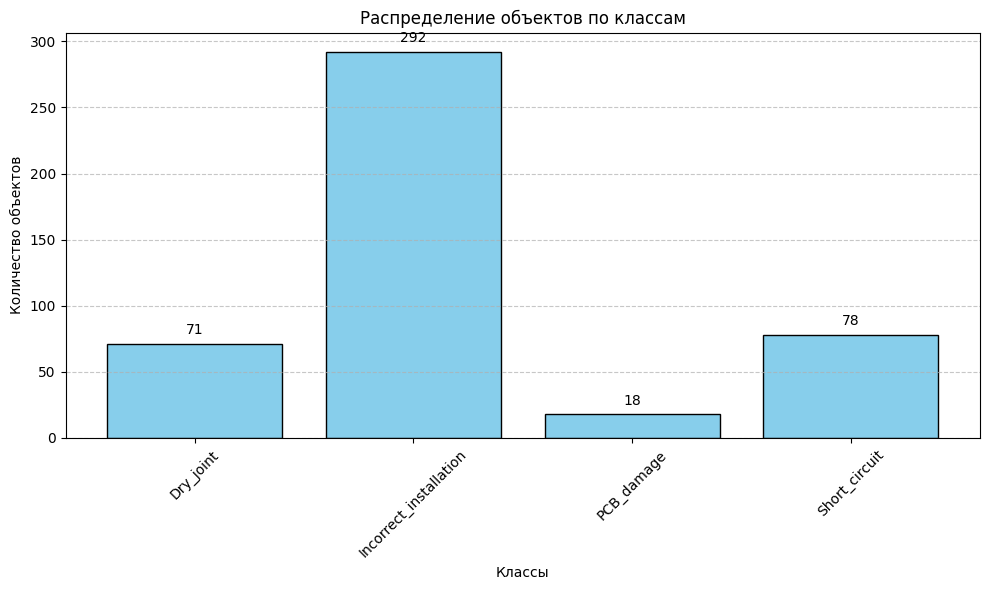

In [14]:
plt.figure(figsize=(10, 6))
bars = plt.bar(names, counts, color='skyblue', edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + max(counts)//50,
             f'{int(yval)}', ha='center', va='bottom', fontsize=10)

plt.title('Распределение объектов по классам')
plt.xlabel('Классы')
plt.ylabel('Количество объектов')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## По сплитам

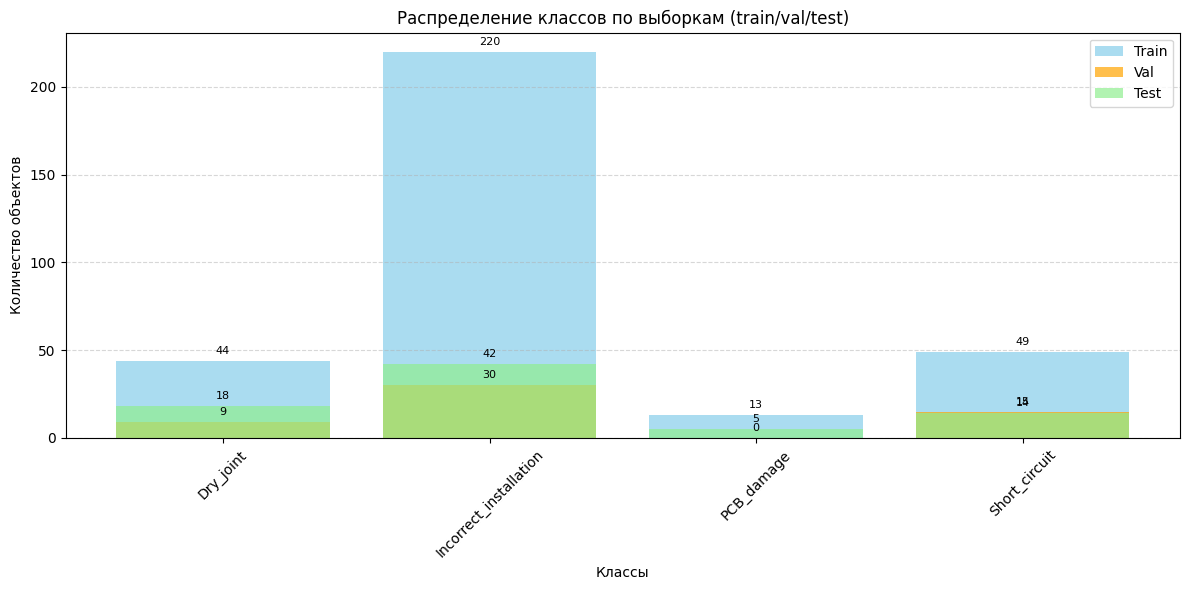

In [ ]:
distribution = get_class_distribution_by_split(DATASET_PATH)

class_ids = sorted(set().union(*[d.keys() for d in distribution.values()]))

train_counts = [distribution['train'].get(cid, 0) for cid in class_ids]
val_counts = [distribution['valid'].get(cid, 0) for cid in class_ids]
test_counts = [distribution['test'].get(cid, 0) for cid in class_ids]

names = [class_names[cid] for cid in class_ids]

bar_width = 0.8
indices = np.arange(len(names))

plt.figure(figsize=(12, 6))

plt.bar(indices, train_counts, width=bar_width, alpha=0.7, label='Train', color='skyblue')
plt.bar(indices, val_counts, width=bar_width, alpha=0.7, label='Val', color='orange')
plt.bar(indices, test_counts, width=bar_width, alpha=0.7, label='Test', color='lightgreen')

for i in range(len(names)):
    plt.text(i, train_counts[i] + max(max(train_counts), max(val_counts), max(test_counts)) // 50,
             str(train_counts[i]), ha='center', fontsize=8)
    plt.text(i, val_counts[i] + max(max(train_counts), max(val_counts), max(test_counts)) // 50,
             str(val_counts[i]), ha='center', fontsize=8)
    plt.text(i, test_counts[i] + max(max(train_counts), max(val_counts), max(test_counts)) // 50,
             str(test_counts[i]), ha='center', fontsize=8)

plt.title('Распределение классов по выборкам (train/val/test)')
plt.xlabel('Классы')
plt.ylabel('Количество объектов')
plt.xticks(indices, names, rotation=45)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Статистика

## По всему датасету

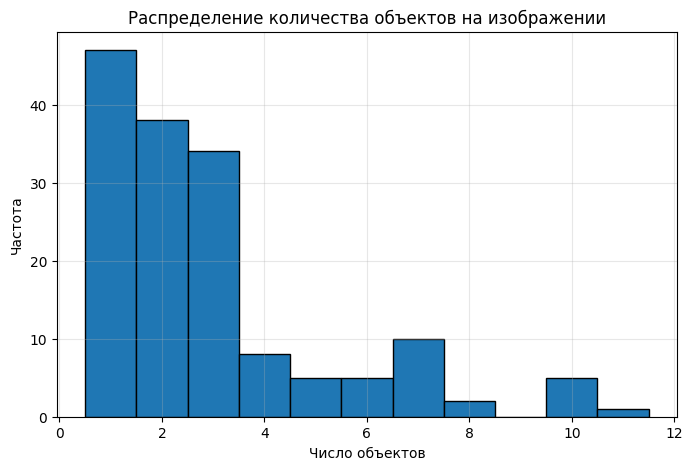

In [15]:
object_per_image = []

for split in ['train', 'valid', 'test']:
    label_dir = Path(DATASET_PATH) / split / 'labels'
    for file in os.listdir(label_dir):
        if file.endswith('.txt'):
            with open(label_dir / file, 'r') as f:
                object_per_image.append(len(f.readlines()))

plt.figure(figsize=(8, 5))
plt.hist(object_per_image, bins=range(1, max(object_per_image)+2), edgecolor='black', align='left')
plt.title("Распределение количества объектов на изображении")
plt.xlabel("Число объектов")
plt.ylabel("Частота")
plt.grid(True, alpha=0.3)
plt.show()

## По сплитам

In [31]:
object_per_image_by_split = {
    'train': [],
    'valid': [],
    'test': []
}

for split in ['train', 'valid', 'test']:
    label_dir = Path(DATASET_PATH) / split / 'labels'
    for file in os.listdir(label_dir):
        if file.endswith('.txt'):
            with open(label_dir / file, 'r') as f:
                lines = f.readlines()
                object_per_image_by_split[split].append(len(lines))

In [32]:
max_objects = max(
    max(object_per_image_by_split['train'], default=0),
    max(object_per_image_by_split['valid'], default=0),
    max(object_per_image_by_split['test'], default=0)
)

bins = range(0, max_objects + 2)  # +2 чтобы последний бин включал максимальное значение

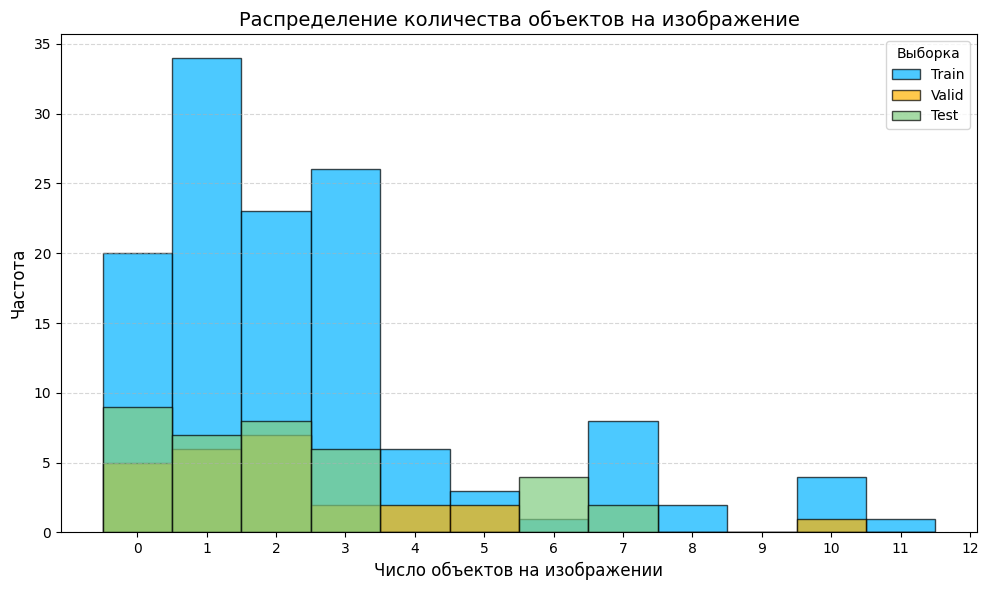

In [ ]:
plt.figure(figsize=(10, 6))

# Цвета для выборок
colors = {
    'train': (0, 0.7, 1, 0.6),     # светло-синий с прозрачностью
    'valid': (1, 0.7, 0, 0.6),     # оранжевый
    'test': (0.5, 0.8, 0.5, 0.6)   # светло-зелёный
}

# Рисуем каждую гистограмму
for split, color in colors.items():
    plt.hist(object_per_image_by_split[split], bins=bins, alpha=0.7,
             edgecolor='black', align='left', color=color, label=split.capitalize())

# Настройки графика
plt.title("Распределение количества объектов на изображение", fontsize=14)
plt.xlabel("Число объектов на изображении", fontsize=12)
plt.ylabel("Частота", fontsize=12)
plt.xticks(bins)
plt.legend(title="Выборка")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Heatmap

In [16]:
MAP_SIZE = (640, 640)
num_classes = len(class_names)
heatmaps = [np.zeros(MAP_SIZE, dtype=np.float32) for _ in range(num_classes)]

In [17]:
def load_annotations(label_path, img_shape):
    h, w = img_shape[:2]
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    polygons = []
    class_ids = []
    for line in lines:
        data = list(map(float, line.strip().split()))
        class_id = int(data[0])
        coords = np.array(data[1:]).reshape(-1, 2)
        coords[:, 0] *= w  # x
        coords[:, 1] *= h  # y
        polygons.append(coords.astype(np.int32))
        class_ids.append(class_id)
    
    return polygons, class_ids

In [ ]:
for split in ['train', 'valid', 'test']:
    img_dir = Path(DATASET_PATH) / split / 'images'
    label_dir = Path(DATASET_PATH) / split / 'labels'

    for label_file in tqdm(os.listdir(label_dir), desc=f'Processing {split}'):
        if not label_file.endswith('.txt'):
            continue

        base_name = label_file.replace('.txt', '')
        image_file = None
        for ext in ['.jpg', '.png', '.jpeg']:
            if os.path.exists(img_dir / (base_name + ext)):
                image_file = img_dir / (base_name + ext)
                break
        if not image_file:
            continue

        image = cv2.imread(str(image_file))
        h, w = image.shape[:2]

        label_path = label_dir / label_file
        polygons, class_ids = load_annotations(label_path, image.shape)

        for polygon, cls_id in zip(polygons, class_ids):
            temp_mask = np.zeros((h, w), dtype=np.uint8)
            cv2.fillPoly(temp_mask, [polygon], color=1)
            resized_mask = cv2.resize(temp_mask, MAP_SIZE[::-1], interpolation=cv2.INTER_LINEAR)
            heatmaps[cls_id] += resized_mask.astype(np.float32)

Processing train:   0%|          | 0/128 [00:00<?, ?it/s]

Processing valid:   0%|          | 0/25 [00:00<?, ?it/s]

Processing test:   0%|          | 0/36 [00:00<?, ?it/s]

In [20]:
for i in range(num_classes):
    heatmap = heatmaps[i]
    if heatmap.max() > 0:
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min()) * 255
    heatmaps[i] = heatmap.astype(np.uint8)

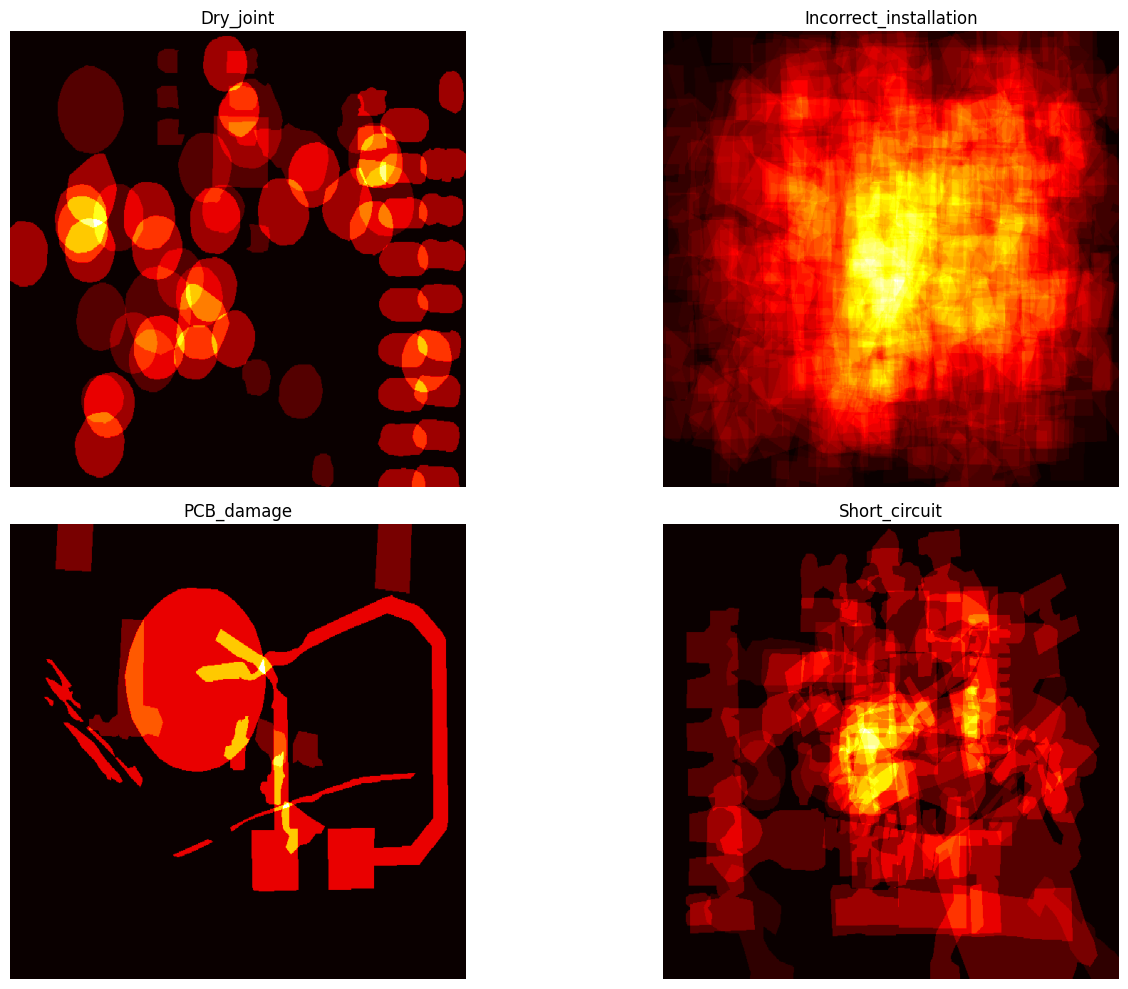

In [21]:
plt.figure(figsize=(15, 10))

for i in range(num_classes):
    plt.subplot(2, 2, i+1)
    plt.imshow(heatmaps[i], cmap='hot')
    plt.title(f'{class_names[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Визуализация

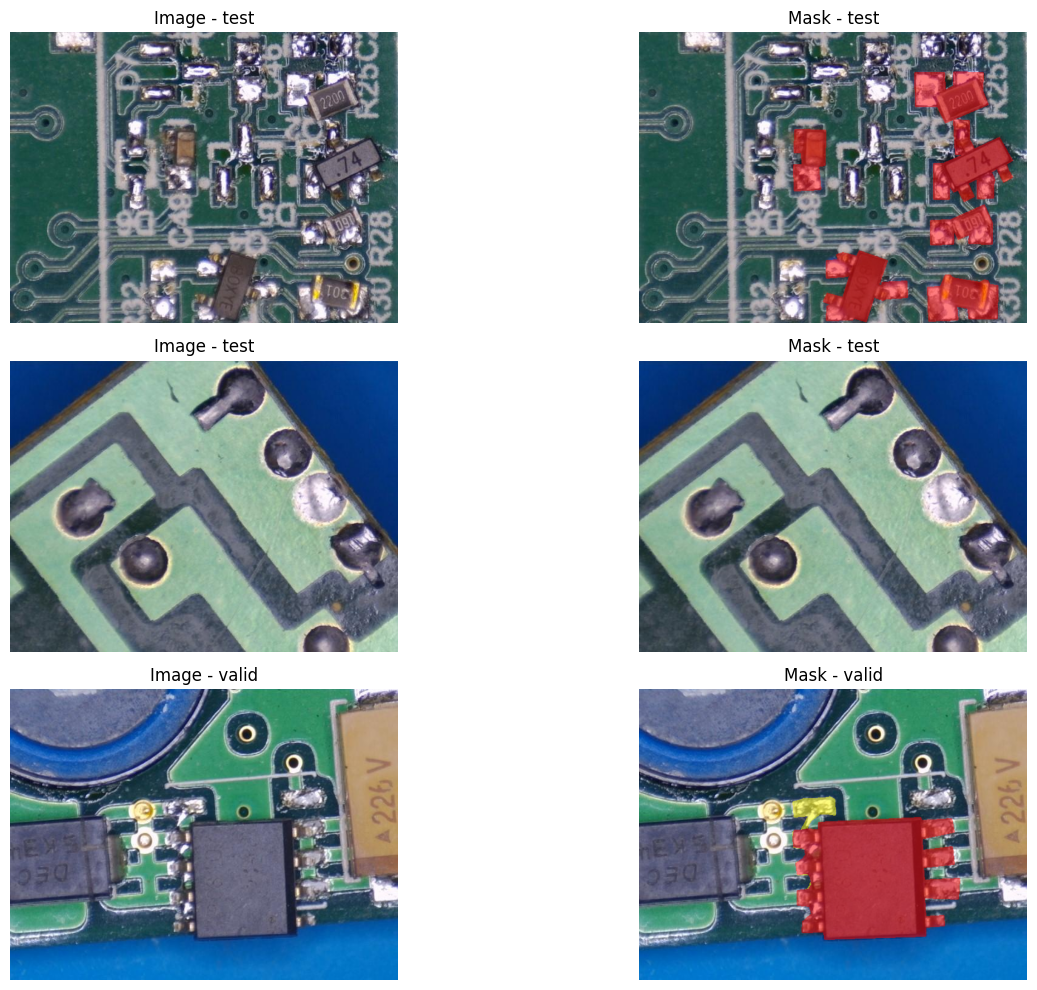

In [39]:
num_samples = 3
splits = ['train', 'valid', 'test']
color_map = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]

plt.figure(figsize=(15, 10))

for i in range(num_samples):
    split = random.choice(splits)
    img_dir = os.path.join(DATASET_PATH, split, 'images')
    label_dir = os.path.join(DATASET_PATH, split, 'labels')
    img_file = random.choice([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))])
    base_name = os.path.splitext(img_file)[0]

    img_path = os.path.join(img_dir, img_file)
    label_path = os.path.join(label_dir, base_name + '.txt')

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    polygons, class_ids = load_yolo_segmentation(label_path, image.shape)

    masked_image = draw_polygons(image.copy(), polygons, class_ids, color_map)

    plt.subplot(num_samples, 2, i * 2 + 1)
    plt.imshow(image)
    plt.title(f"Image - {split}")
    plt.axis('off')

    plt.subplot(num_samples, 2, i * 2 + 2)
    plt.imshow(masked_image)
    plt.title(f"Mask - {split}")
    plt.axis('off')

plt.tight_layout()
plt.show()